In [123]:
# %load std_libraries.py
#to keep my scripts consistent, I am adding this to the top of all scripts with %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Bens, b = gpucluster, c = other   ")
location_dict = {'a': "C:\\Users\\heine\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",'c':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib_venn import venn2
#import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
#import scipy.stats as stats
#import statsmodels.graphics.gofplots as stats_graph
#import scipy.cluster.hierarchy as sch

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

what computer are you on? a = Bens, b = gpucluster, c = other   a
base directory is C:\Users\heine\github\expression_broad_data
I am about to import a library
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
are you online? Yes/NoYes


In [114]:
#read in gis, rph data
gis1_rph1_data_fname = os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_norm_data.txt')
gis1_rph1_data = pd.read_table(gis1_rph1_data_fname)
gis1_rph1_data.set_index('Hybridization REF', inplace=True)
gis1_rph1_data.drop(labels = 'Composite Element REF', axis = 0, inplace=True)
gis1_rph1_data = gis1_rph1_data.astype('float')


#read in array info
arraydata_fname = os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'A-AFFY-27.adf.txt')
arraydata = pd.read_table(arraydata_fname, skiprows=16)

#map data to array: 
genes_counter = Counter(arraydata['Composite Element Database Entry[sgd]'])
#repeated_genes = [gene for gene, NN in genes_counter.items() if NN>1]
spots_with_genes = arraydata[arraydata['Composite Element Database Entry[sgd]'].isin(list(genes_counter.keys())[1:])]  #start at 1 because 0 is nul
spots_with_genes_dict = dict(zip(spots_with_genes['Composite Element Name'],spots_with_genes['Composite Element Database Entry[sgd]']))
gis1_rph1_data_sgd = gis1_rph1_data.loc[spots_with_genes_dict.keys()]
gis1_rph1_data_sgd['sc_genename'] = spots_with_genes_dict.values()
#take mean of columns with duplicated values. 
grouped = gis1_rph1_data_sgd.groupby('sc_genename')
gis1_rph1_data_sgd_mean = grouped.mean()

#rename inconsistently named columns: 
gis1_rph1_data_sgd_mean.rename(columns = {'JO01_wt_a log': 'JO01_wt_a_log', 'JO02_wt_b log': 'JO02_wt_b_log', 'JO03_wt_c log' : 'JO03_wt_c_log',
                                          'JO04_g_a_ log': 'JO04_g_a_log', 'JO05_g_b_ log': 'JO05_g_b_log', 'JO06_g_c_ log' : 'JO06_g_c_log', 
                                          'JO07_r_a_ log': 'JO07_r_a_log', 'JO08_r_b_ log': 'JO08_r_b_log', 'JO09_r_c_ log' : 'JO09_r_c_log'},
                               inplace=True)

#These columns are the missing gis1 and wt 3 day measurments.  Process them separately. 
gis1_rph1_data_sgd_missing_gis13day = gis1_rph1_data_sgd_mean.loc[:,['JOW1_wt1', 'JOW2_wt2', 'JOW3_wt3', 'JOW4_gis1_1','JOW5_gis1_2', 'JOW6_gis1_3']]

gis1_rph1_data_sgd_mean.drop(labels = ['JOW1_wt1', 'JOW2_wt2', 'JOW3_wt3', 'JOW4_gis1_1','JOW5_gis1_2', 'JOW6_gis1_3'],
                             axis = 1, inplace = True)

#Average over repeats. 
#build multiindex over columns
conditions = []
strains = []
for column in gis1_rph1_data_sgd_mean.columns: 
    split_str = column.split('_')
    strain = split_str[1]
    strains.append(strain)
    
    condition = split_str[3]
    conditions.append(condition)
    
    #cond_strains.append(condition + '_' + strain)

col_multiindex= pd.MultiIndex.from_arrays([gis1_rph1_data_sgd_mean.columns, conditions, strains],names=['exp','condition', 'strain'])
gis1_rph1_data_sgd_mean.columns = col_multiindex
exp_groups = gis1_rph1_data_sgd_mean.groupby(level = ['condition', 'strain'], axis = 1)
gis1_rph1_data_sgd_mean2 = exp_groups.mean()       

#Make fold change columns for each growth condition. 
gis1_rph1_data_fc = pd.DataFrame(index=gis1_rph1_data_sgd_mean2.index)
conditions = ['log', 'PDS']   #, '3d']  #missing 3d for gis1 probably last data set 
strains = ['g','r','gr']
for condition in conditions: 
    wt_data = gis1_rph1_data_sgd_mean2.xs((condition,'wt'), level=('condition', 'strain'), axis=1)
    wt_data.columns = ['data']
    for strain in strains: 
        strain_data = gis1_rph1_data_sgd_mean2.xs((condition,strain), level=('condition', 'strain'), axis=1)
        strain_data.columns = ['data']
        gis1_rph1_data_fc[condition + '_' + strain + '-wt'] = strain_data - wt_data     

# Get contrast for r, gr on 3day
condition = '3d'
strains = ['r','gr']
wt_data = gis1_rph1_data_sgd_mean2.xs((condition,'wt'), level=('condition', 'strain'), axis=1)
wt_data.columns = ['data']
for strain in strains: 
    strain_data = gis1_rph1_data_sgd_mean2.xs((condition,strain), level=('condition', 'strain'), axis=1)
    strain_data.columns = ['data']
    gis1_rph1_data_fc[condition + '_' + strain + '-wt'] = strain_data - wt_data     
        

# get contrast for g on 3 day
gis1_rph1_data_sgd_missing_gis13day

#Average over repeats. 
#build multiindex over columns
strains = ['wt','wt','wt','g','g','g']
col_multiindex= pd.MultiIndex.from_arrays([gis1_rph1_data_sgd_missing_gis13day.columns, strains],names=['exp','strain'])
gis1_rph1_data_sgd_missing_gis13day.columns = col_multiindex

exp_groups = gis1_rph1_data_sgd_missing_gis13day.groupby(level = ['strain'], axis = 1)
gis1_rph1_data_sgd_missing_gis13day_mean = exp_groups.mean()  

gis1_rph1_data_fc['3d_g-wt'] = gis1_rph1_data_sgd_missing_gis13day_mean['g'] - gis1_rph1_data_sgd_missing_gis13day_mean['wt']

gis1_rph1_data_fc.to_csv(os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_data_fc.csv'))




In [111]:
gis1_rph1_data_fc = pd.read_csv(os.path.normpath(data_processing_dir + 'gis1_rph1_data' + os.sep + 'gis1_rph1_data_fc.csv'), index_col='sc_genename')

fname_cross_spec_comparison = data_processing_dir + os.path.normpath("20170817_klscpka/cross_species_compare_ASminus_ASplus_YPD.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)


In [134]:
#There are 1251 of the S.Cer genes in my kl_sc_PKA dataset that doesn't show up on the gene chip - it is based on a 1998 version of SGD.  
#There are many other genomic features that are on the chip that don't show up in my data per a recent annotation of SCer. 
#This list has the missing genes from my dataset (includes ROX1 and NQM1, among others)
io_library.SC_common_name_lookup(list(set(kl_sc_PKA_data['sc_genename']) - set(gis1_rph1_data_fc.index)))

['YBR242W',
 'YIL102C-A',
 'YSP3',
 'OPY1',
 'AEP3',
 'NOP7',
 'REX3',
 'GEP5',
 'COX26',
 'BUD27',
 'MUM3',
 'YKL050C',
 'HXT3',
 'SSU1',
 'RCR1',
 'IBA57',
 'HTA2',
 'RHO4',
 'SEC8',
 'APE4',
 'GAC1',
 'THG1',
 'TPP1',
 'SPC42',
 'TMA17',
 'AIM46',
 'EMI1',
 'UPS3',
 'CTI6',
 'LSB6',
 'EXO84',
 'HEM14',
 'CDC26',
 'QDR3',
 'ELO1',
 'SHE1',
 'VCX1',
 'PEP5',
 'TTI2',
 'MOH1',
 'INO4',
 'ATG4',
 'PRO3',
 'FKH1',
 'REG1',
 'PRT1',
 'MCM21',
 'HPT1',
 'YJL133C-A',
 'CDC53',
 'RBK1',
 'MRPL33',
 'TDA11',
 'CHS1',
 'YBR085C-A',
 'NAB3',
 'RAD33',
 'SYC1',
 'CDC7',
 'SPC34',
 'PHO85',
 'DPB4',
 'RPS18A',
 'PFS1',
 'CCW14',
 'RQC2',
 'YBR056W-A',
 'PDP3',
 'VPS17',
 'PRP24',
 'VIK1',
 'YPL107W',
 'YBL029C-A',
 'MNL2',
 'YPL260W',
 'YSC83',
 'RFU1',
 'DAL2',
 'ESF1',
 'RSM23',
 'RNP1',
 'CTF3',
 'VBA4',
 'CCT8',
 'UFO1',
 'YKL068W-A',
 'PEX29',
 'DAD4',
 'YIL161W',
 'VTC4',
 'MDV1',
 'LDB19',
 'MET17',
 'NET1',
 'SLY41',
 'SPT21',
 'RPL29',
 'MRPL10',
 'POP3',
 'SIW14',
 'EHD3',
 'SRP40',
 'L

In [74]:
#get overlap of genes with the msn2/4 rlog data from solis
#Load rlog data
rlog_data = pd.read_csv(data_processing_dir + os.path.normpath('SCer_NMPP1_RNA_Seq/solis_2016_msn24_rlog.csv'))
rlog_data.rename(columns = {'Unnamed: 0': 'sc_genename'}, inplace = True)
rlog_data['SC_common_name'] = io_library.SC_common_name_lookup(list(rlog_data['sc_genename']))
#rlog_data_to_merge = rlog_data.rename(columns={col: 'solis_rlog_'+ col for col in ['AS_1NMPP1', 'AS_cont', 'msn24del_1NMPP1','msn24del_cont']})
#rlog_data_to_merge = rlog_data_to_merge.loc[:,rlog_data_to_merge.columns[0:-1]]


In [17]:
print("There are {:d} out of {:d} genes in the gis1_rph1 dataset that are not present in the solis dataset".format(len(set(gis1_rph1_data_fc.index)-set(rlog_data['sc_genename'])),
                                                                                                                  len(gis1_rph1_data_fc.index)
                                                                                                                  ))
print("There are {:d} out of {:d} genes in the solis dataset that are not present in the gis1_rph1 dataset".format(len(set(rlog_data['sc_genename'])-set(gis1_rph1_data_fc.index)),
                                                                                                                  len(rlog_data['sc_genename'])                                                                                                             ))

io_library.SC_common_name_lookup(list(set(rlog_data['sc_genename']) - set(gis1_rph1_data_fc.index)))

There are 2332 out of 6809 genes in the gis1_rph1 dataset that are not present in the solis dataset
There are 1949 out of 6426 genes in the solis dataset that are not present in the gis1_rph1 dataset


['YER148W-A',
 'YER133W-A',
 'API2',
 'CUZ1',
 'YHR218W',
 'YIL047C-A',
 'YMR158C-A',
 'YKR012C',
 'YER172C-A',
 'SBE2',
 'PIK1',
 'YPL014W',
 'HER1',
 'UGP1',
 'HEF3',
 'HHF1',
 'GPI14',
 'YAR009C',
 'PDC2',
 'UBC5',
 'ATG7',
 'MOH1',
 'TDA8',
 'YHL026C',
 'AIM23',
 'SNF11',
 'AI4',
 'YNR025C',
 'SHR3',
 'BEM1',
 'GYP5',
 'ATG34',
 'RSM25',
 'ATP3',
 'BUL1',
 'DBP5',
 'YDR249C',
 'YHR140W',
 'SNA4',
 'YHR050W-A',
 'RIX1',
 'YLR042C',
 'YGR054W',
 'DSD1',
 'SHE9',
 'SPC42',
 'SPC72',
 'CHM7',
 'NUP57',
 'WIP1',
 'STE50',
 'NTG2',
 'PHB1',
 'YKL023C-A',
 'YBR056W',
 'YBL028C',
 'YLR334C',
 'YJL113W',
 'LSM4',
 'INO4',
 'YHL019W-A',
 'SPP1',
 'YOR376W-A',
 'VAM6',
 'RIT1',
 'YER046W-A',
 'RLP7',
 'YOR392W',
 'GTB1',
 'YOL013W-B',
 'NUP53',
 'YER137W-A',
 'PAC2',
 'SRM1',
 'YOR186W',
 'YER138C',
 'TEN1',
 'FOL3',
 'COS111',
 'YPR137C-B',
 'RSM22',
 'CIR1',
 'YLR256W-A',
 'PCD1',
 'NBP35',
 'HXT17',
 'SEC66',
 'RTS3',
 'HMI1',
 'MMS1',
 'ATG5',
 'YGR161W-C',
 'ILS1',
 'YOR139C',
 'GEA1',
 

In [19]:
for thresh in [1.0,2.0,3.0]:
    print(thresh)
    for column in gis1_rph1_data_fc.columns:
        print('increase: {:2d} column: {}'.format(sum(gis1_rph1_data_fc[column]>thresh),column) )
        print('decrease: {:2d} column: {}'.format(sum(gis1_rph1_data_fc[column]<-thresh),column))   

1.0
increase: 49 column: log_g-wt
decrease: 78 column: log_g-wt
increase: 70 column: log_r-wt
decrease: 12 column: log_r-wt
increase: 163 column: log_gr-wt
decrease: 42 column: log_gr-wt
increase: 89 column: PDS_g-wt
decrease: 71 column: PDS_g-wt
increase: 20 column: PDS_r-wt
decrease: 50 column: PDS_r-wt
increase: 219 column: PDS_gr-wt
decrease: 222 column: PDS_gr-wt
increase: 100 column: 3d_r-wt
decrease: 283 column: 3d_r-wt
increase: 163 column: 3d_gr-wt
decrease: 214 column: 3d_gr-wt
increase: 215 column: 3d_g-wt
decrease: 116 column: 3d_g-wt
2.0
increase:  1 column: log_g-wt
decrease:  8 column: log_g-wt
increase:  3 column: log_r-wt
decrease:  1 column: log_r-wt
increase: 26 column: log_gr-wt
decrease:  9 column: log_gr-wt
increase:  1 column: PDS_g-wt
decrease: 15 column: PDS_g-wt
increase:  1 column: PDS_r-wt
decrease:  4 column: PDS_r-wt
increase:  8 column: PDS_gr-wt
decrease: 28 column: PDS_gr-wt
increase:  7 column: 3d_r-wt
decrease: 14 column: 3d_r-wt
increase: 23 column: 

<IPython.core.display.Javascript object>


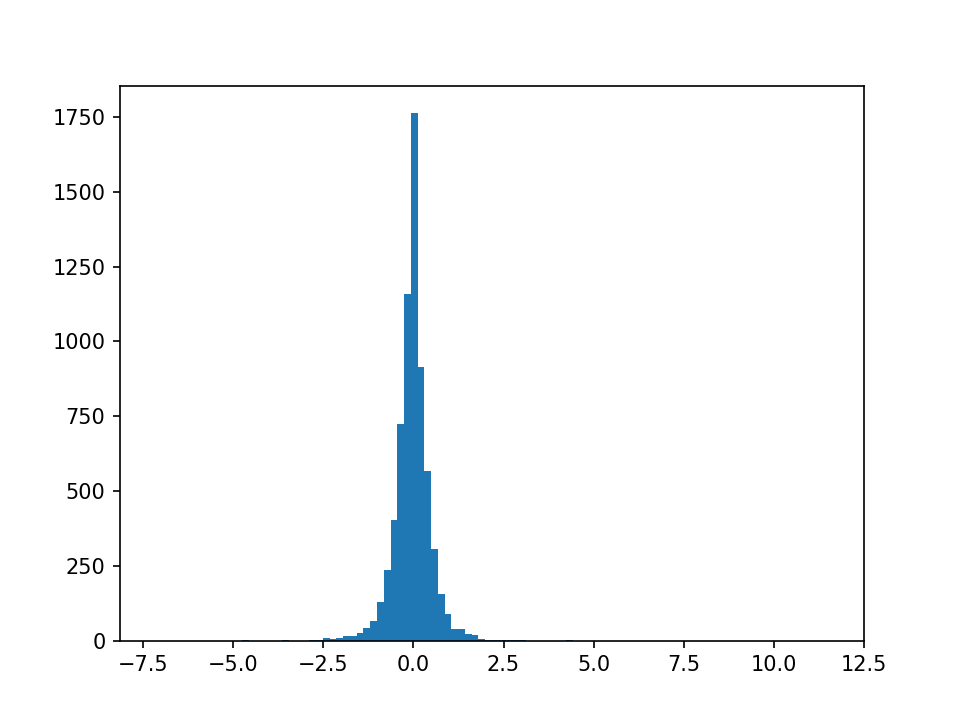

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   3.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          4.00000000e+00,   9.00000000e+00,   5.00000000e+00,
          8.00000000e+00,   1.50000000e+01,   1.60000000e+01,
          2.60000000e+01,   4.40000000e+01,   6.70000000e+01,
          1.28000000e+02,   2.38000000e+02,   4.04000000e+02,
          7.25000000e+02,   1.15900000e+03,   1.76400000e+03,
          9.15000000e+02,   5.68000000e+02,   3.06000000e+02,
          1.56000000e+02,   8.90000000e+01,   4.00000000e+01,
          4.00000000e+01,   2.20000000e+01,   1.90000000e+01,
        

In [7]:
plt.hist(gis1_rph1_data_fc['3d_gr-wt'],bins=100)

In [ ]:
#The original paper found 270 genes differentially regulated in log phase - this seems like it will be somewhere in between 1 and 2 for a cutoff. 

In [1]:
#merge with my KL/SC data
kl_sc_PKA_data_gr = kl_sc_PKA_data.merge(gis1_rph1_data_fc, left_on = 'sc_genename', right_index=True, how = 'inner')

#Use cutoff to assign activated, inhibited, and repressed for gis1, rph1 and gis1rph1 for each condition
act_threshold = 1
inh_threshold = -1

rg_columns = ['log_g-wt','log_r-wt', 'log_gr-wt', 'PDS_g-wt', 'PDS_r-wt', 'PDS_gr-wt', '3d_r-wt','3d_gr-wt', '3d_g-wt']
for column in rg_columns: 
    kl_sc_PKA_data_gr[column+'_label'] = io_library.threshold_group_series(kl_sc_PKA_data_gr[column], act_threshold, inh_threshold )


NameError: name 'kl_sc_PKA_data' is not defined

In [175]:
#Make list of genes for each condition that have 
gr_sets = {}
conditions = ['log', 'PDS','3d']
strains = ['g','r','gr']
for condition in conditions:
    gr_sets_cond = {}
    exp_profiles = tuple(product(['up','flat','down'],['up','flat','down'],['up','flat','down']))
    for g_label, r_label, gr_label in exp_profiles:
        gr_sets_cond['g-'+g_label + '_r-'+r_label + '_gr-'+gr_label] = list(kl_sc_PKA_data_gr[(kl_sc_PKA_data_gr[condition + '_g-wt_label']==g_label) &
                                                                      (kl_sc_PKA_data_gr[condition + '_r-wt_label']==r_label) &
                                                                      (kl_sc_PKA_data_gr[condition + '_gr-wt_label']==gr_label)]['sc_genename'])
    gr_sets[condition] = gr_sets_cond

gr_sets
            


{'3d': {'g-down_r-down_gr-down': ['YDR308C'],
  'g-down_r-down_gr-flat': [],
  'g-down_r-down_gr-up': [],
  'g-down_r-flat_gr-down': ['YKR076W',
   'YDL218W',
   'YMR169C',
   'YKL107W',
   'YMR170C',
   'YGR052W',
   'YGR256W',
   'YBL075C',
   'YMR118C',
   'YDL085W',
   'YPL223C',
   'YDL223C',
   'YJL045W',
   'YDR096W',
   'YLR164W'],
  'g-down_r-flat_gr-flat': ['YBR280C',
   'YML128C',
   'YOR107W',
   'YER127W',
   'YDR256C',
   'YDR432W',
   'YOR283W',
   'YDR464W',
   'YHR085W',
   'YNL075W',
   'YDR167W',
   'YNL115C',
   'YOL010W',
   'YDR397C',
   'YDR465C',
   'YER030W',
   'YEL026W',
   'YLR109W',
   'YDL169C',
   'YKL009W',
   'YLR070C',
   'YNL110C',
   'YDR075W',
   'YER029C',
   'YLR284C',
   'YMR036C',
   'YIL057C',
   'YDL222C',
   'YMR175W',
   'YPR158W',
   'YNL009W',
   'YEL030W'],
  'g-down_r-flat_gr-up': ['YLR367W', 'YDR111C'],
  'g-down_r-up_gr-down': [],
  'g-down_r-up_gr-flat': ['YER002W', 'YBR212W'],
  'g-down_r-up_gr-up': ['YPR101W', 'YJL191W'],
  'g-flat_

In [176]:
#print out numbers for gr_sets
for condition in conditions: 
    print(condition)
    for key, item in gr_sets[condition].items():
        print(key + ': ' + str(len(item)))

log
g-up_r-up_gr-up: 9
g-up_r-up_gr-flat: 1
g-up_r-up_gr-down: 0
g-up_r-flat_gr-up: 2
g-up_r-flat_gr-flat: 14
g-up_r-flat_gr-down: 2
g-up_r-down_gr-up: 0
g-up_r-down_gr-flat: 0
g-up_r-down_gr-down: 0
g-flat_r-up_gr-up: 12
g-flat_r-up_gr-flat: 13
g-flat_r-up_gr-down: 0
g-flat_r-flat_gr-up: 52
g-flat_r-flat_gr-flat: 3562
g-flat_r-flat_gr-down: 12
g-flat_r-down_gr-up: 0
g-flat_r-down_gr-flat: 2
g-flat_r-down_gr-down: 1
g-down_r-up_gr-up: 0
g-down_r-up_gr-flat: 2
g-down_r-up_gr-down: 0
g-down_r-flat_gr-up: 2
g-down_r-flat_gr-flat: 37
g-down_r-flat_gr-down: 1
g-down_r-down_gr-up: 0
g-down_r-down_gr-flat: 1
g-down_r-down_gr-down: 0
PDS
g-up_r-up_gr-up: 2
g-up_r-up_gr-flat: 0
g-up_r-up_gr-down: 0
g-up_r-flat_gr-up: 16
g-up_r-flat_gr-flat: 34
g-up_r-flat_gr-down: 0
g-up_r-down_gr-up: 0
g-up_r-down_gr-flat: 0
g-up_r-down_gr-down: 0
g-flat_r-up_gr-up: 5
g-flat_r-up_gr-flat: 1
g-flat_r-up_gr-down: 0
g-flat_r-flat_gr-up: 114
g-flat_r-flat_gr-flat: 3421
g-flat_r-flat_gr-down: 83
g-flat_r-down_gr-up

In [178]:
kl_sc_PKA_data_gr.columns

Index(['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
       'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL',
       'rlog_AS_noNMPP1_YPD_t40_mean_KL', 'rlog_AS_yesNMPP1_YPD_t40_mean_KL',
       'rlog_AS_noNMPP1_YPD_t40_var_KL', 'rlog_AS_yesNMPP1_YPD_t40_var_KL',
       'raw_AS_noNMPP1_YPD_t40_mean_KL', 'raw_AS_yesNMPP1_YPD_t40_mean_KL',
       'raw_AS_noNMPP1_YPD_t40_var_KL', 'raw_AS_yesNMPP1_YPD_t40_var_KL',
       'baseMean_SC', 'log2FoldChange_SC', 'lfcSE_SC', 'stat_SC', 'pvalue_SC',
       'padj_SC', 'rlog_AS_noNMPP1_YPD_t40_mean_SC',
       'rlog_AS_yesNMPP1_YPD_t40_mean_SC', 'rlog_AS_noNMPP1_YPD_t40_var_SC',
       'rlog_AS_yesNMPP1_YPD_t40_var_SC', 'raw_AS_noNMPP1_YPD_t40_mean_SC',
       'raw_AS_yesNMPP1_YPD_t40_mean_SC', 'raw_AS_noNMPP1_YPD_t40_var_SC',
       'raw_AS_yesNMPP1_YPD_t40_var_SC', 'SC_common_name', 'log_g-wt',
       'log_r-wt', 'log_gr-wt', 'PDS_g-wt', 'PDS_r-wt', 'PDS_gr-wt', '3d_r-wt',
       '3d_gr-wt', '3d_g-wt', 'log_g-w

In [182]:
for condition in conditions:    # condition = 'log'

    #Plot kl v.s. sc with overlay from gis1 rph1 experiment

    hover_text = []
    for ind, row in kl_sc_PKA_data_gr.iterrows():
        hover_text.append(('{SC_common_name}<br>{gminwt}<br>{rminwt}<br>{grminwt}').format(
                                  SC_common_name=row['SC_common_name'],
                                  gminwt = row[condition + '_g-wt'], 
                                  rminwt = row[condition + '_r-wt'],
                                  grminwt = row[condition + '_gr-wt']))

    kl_sc_PKA_data_gr['hover_'+condition] = hover_text

    data = []

    for strain_phenotypes, genes in gr_sets[condition].items():
        kl_sc_PKA_data_gr_subset = kl_sc_PKA_data_gr[kl_sc_PKA_data_gr['sc_genename'].isin(genes)]

        trace = pygo.Scatter(
            x = kl_sc_PKA_data_gr_subset['log2FoldChange_KL'],
            y =  kl_sc_PKA_data_gr_subset['log2FoldChange_SC'],
            text = kl_sc_PKA_data_gr_subset['hover_'+condition],
            mode = 'markers',
            marker = {'opacity': 0.5},
            name = strain_phenotypes
        )

        data.append(trace)

    layout = pygo.Layout(
        xaxis= {
            #"range":[-2, 20],
            "title":'K.Lac LFC'
        },
        yaxis= {
            #"range":[-2, 20],
            "title":'S.Cer LFC'
        }
    )


    fig = pygo.Figure(data=data, layout = layout)
    py.iplot(fig, filename='rph1_gis1_projection_'+ condition)

In [166]:
g_label = 'up'
r_label = 'up'
gr_label = 'up'
list(kl_sc_PKA_data_gr[(kl_sc_PKA_data_gr['log_g-wt_label']==g_label) &
                  (kl_sc_PKA_data_gr['log_r-wt_label']==r_label) &
                  (kl_sc_PKA_data_gr['log_gr-wt_label']==gr_label)]['sc_genename'])

['YPR160W',
 'YPR127W',
 'YNL274C',
 'YOR052C',
 'YPL230W',
 'YOR185C',
 'YER062C',
 'YMR105C',
 'YEL039C']

In [20]:
# YJL136w-a lowercase is that a problem to link up with mine? 

# Load Kemmeren deletion data (in log phase) because that should capture more genes from my set

In [26]:
#microarray_info.ix(?) #[1,'SYSTEMATIC_NAME']==microarray_info['ORF']
X = microarray_info.loc[:,'SYSTEMATIC_NAME']
X.fillna('NONE', inplace=True)
Y = microarray_info.loc[:,'ORF']
Y.fillna('NONE', inplace=True)
X[~(X==Y)]
#Y[~(X==Y)]

5277    YGR226C
5444    YGR226C
Name: SYSTEMATIC_NAME, dtype: object

YGR226C is unlikely to be an orfbut since it is present under systematic name and not orf, I'll use systematic name for the dictionary. 

In [45]:

desired_conditions = {'gis1_1':'GSM819531', 'gis1_2':'GSM819532',
                      'rph1_1':'GSM636524', 'rph1_2':'GSM636525',
                      'gis1rph1_1':'GSM1044545', 'gis1rph1_2': 'GSM1044546'}

array_inds

{'gis1_1': 17,
 'gis1_2': 18,
 'gis1rph1_1': 180,
 'gis1rph1_2': 181,
 'rph1_1': 8,
 'rph1_2': 9}

In [62]:
ids = microarray_lookup.keys()
int(linesp[0]) in set(ids)

True

In [56]:
ids

dict_keys([2, 3, 5, 7, 8, 9, 11, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 73, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142, 143, 144, 146, 148, 150, 151, 152, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 170, 173, 174, 177, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 206, 207, 208, 209, 211, 212, 213, 214, 215, 216, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 237, 238, 240, 241, 242, 244, 245, 246, 247, 249, 250, 251, 252, 254, 255, 256, 257, 258, 259, 260, 261, 262, 26

In [63]:
desired_conditions.items()

dict_items([('gis1_1', 'GSM819531'), ('gis1_2', 'GSM819532'), ('rph1_1', 'GSM636524'), ('rph1_2', 'GSM636525'), ('gis1rph1_1', 'GSM1044545'), ('gis1rph1_2', 'GSM1044546')])

In [64]:
desired_conditions.keys()

dict_keys(['gis1_1', 'gis1_2', 'rph1_1', 'rph1_2', 'gis1rph1_1', 'gis1rph1_2'])

In [65]:
array_inds.keys()

dict_keys(['gis1_1', 'gis1_2', 'rph1_1', 'rph1_2', 'gis1rph1_1', 'gis1rph1_2'])

In [59]:
line = "27	-0.0613749	-0.0107950772286601	0.0858791235103082	0.0418335	0.0443294419986702	-0.0477246	-0.0634957288214552	-0.116463	-0.0943806771861452	-0.247447	-0.0892056303225891	0.112846	0.0127254550742741	0.128247	0.10796047937354	-0.0566365	0.0545636	0.136422	-0.00020334	0.206815	0.0688607	-0.0674673	0.204131	-0.0286776	-0.0770332	-0.174145	0.20254	-0.0255692	-0.0283003778139282	0.0807567	0.0757463	-0.0556508853293912	0.000978025214881633	-0.258845	0.248020624589076	0.00367829	-0.024198259895647	0.0948223	-0.0249586890957667	0.0860504	0.069858758258027	-0.0550526	-0.0286645078143613	-0.175199	-0.0403020999347203	0.0964427	-0.0445855	0.0355487892060942	-0.0123675	-0.0241122071156979	0.171054	0.0623944	-0.038795306004976	-0.0116925	-0.0969585961608498	0.100900784055063	0.06038241188	0.0637655	0.0435466582905918	-0.0474559	0.0695019873249175	0.0435045476158045	-0.13344	-0.0656331476556357	0.00921781	0.131870239844784	-0.121456	0.138945236662083	0.0304481	0.0610456731011725	0.139957	0.0616822471264292	0.0584532	0.251900878513673	-0.0365538136644866	0.121195	0.22932257500176	-0.157779	0.0377567	0.127401936069657	-0.139837	-0.170702517628756	0.153963	0.188547650610268	-0.013792	0.0336051804090964	0.0693882874729126	0.140222	0.108140900332718	-0.203471	0.22677581544097	-0.143494	-0.0306455129114851	0.00224311	0.0102393440035723	-0.125342	0.210284254392238	0.109245	0.0433328239653411	-0.116009	-0.00541404481546407	0.179774	0.17948738153798	0.215487	0.0588608627290662	-0.148074	0.0308211611333777	-0.023119265005476	0.0326887	-0.0466827919352927	-0.0370901	-0.0671306501702213	0.0458908	0.0227125540437463	0.0203989	0.0233087392941132	-0.0679488	0.0703474407873011	-0.122911702947386	-0.125452	0.0752922	-0.0431079476046227	-0.148982	0.213360334258031	-0.0247	0.00686358011333478	0.0379658	0.104943387141063	-0.0381645511952902	-0.103355	0.00833040852708256	-0.196271	-0.189149978450639	0.144242	-0.00492064530325344	0.0718846045049057	-0.107171	-0.119670878420181	-0.086299	0.149321655539466	0.0183321	-0.077857446828042	-0.130877	-0.0411271485021918	-0.0834185	0.176833937850523	-0.114367	0.169466593929229	0.222144	0.215287841393525	-0.0114823	0.110377020872287	0.0187668	0.0391963378843642	-0.102657	0.0938013051296459	0.0615307	-0.00737793478450893	-0.109539	0.178352082426823	0.0327352	0.0367896590017395	-0.0527091829471408	-0.0800334	0.0171286	-0.0154704840525086	-0.0428564	-0.0943293555027993	0.0295957	0.00723972733845706	0.0311766	-0.0338084	-0.0691334571786895	-0.0965327	0.0953743813934196	-0.0227922	-0.00355835280962009	-0.196777	0.0719808815771154	0.0541319	0.0504818684578345	0.196141	-0.172598094381906	0.0534185	0.0544702805352109	0.00603665	-0.00332006332193994	-0.222235	-0.141055630723856	0.171966	-0.208627108255453	-0.011126	-0.0880790013123011	-0.0597652	-0.00505814805132509	0.0162908	-0.116675619875181	-0.070638	-0.0775585128246175	0.122773	0.0154917131550023	0.0320082142202599	0.0524886	-0.0985748	0.0114189794518582	0.201712	0.163083884542398	0.0636576	-0.022315	0.13350353550549	-0.105208	-0.0473265038358507	-0.0873373	0.0877677173845411	-0.0910909	0.0653198339565468	-0.207979	0.100103603251383	-0.113917	0.298464805319831	0.116341	0.0349939715629394	-0.00183821	0.155647060030397	-0.0543299	-0.0839853770577551	0.0759406	-0.18477	0.174767275150982	-0.0961172	0.116934627677922	-0.0276871510168981	0.0191286	0.0902866522243162	0.0686122	0.0711999292179506	0.0818011	0.126039	-0.108387933902531	-0.0260648	0.170567327557462	0.0140607727484597	-0.0657274	0.0675318288615536	0.0130829	0.120677624351555	-0.0723903	0.151511239283076	-0.0100522	0.143545089886256	0.0579457	-0.0725712	0.0734708032999773	0.100429	-0.00807503685558658	0.0298132689041117	0.246096	-0.124962370561715	0.10434	0.0831936799690426	-0.100102	0.156164269714602	0.0476874	0.055323217983842	0.0394464	-0.0404494629734763	0.00426123	0.0269932325834388	0.018335	0.0452265758745406	0.0241347	0.010680105996531	0.0478999	-0.0185988421471475	0.0423984	0.0466102	-0.0109192089496097	0.148054	-0.111625493300981	-0.0218016	0.0255061892165733	-0.0661652	0.024257392616577	-0.0509200435505394	-0.0625977754041264	-0.171937	-0.256704386416978"
#"15552	0.440184	0.386752526882975	0.31836850199228	0.677119	0.0455192265964403	0.506131	0.569119628909756	-0.0390941	0.0471323572926712	0.694656	0.0652052981326674	0.115889	0.0856382902387472	-0.160086	0.310473315456678	-0.00309971	-0.216099	0.27166	0.73019	1.0295	0.684674	-0.0388815	0.158315	-0.0122798	0.341776	0.31654	0.258601	0.0509789	0.210591136231364	0.752441	0.22131	-0.256694279424972	-0.149351012075823	-0.521295	0.567121439321811	-0.492954	0.534152333599659	0.328527	0.798243109705551	0.399373	1.20594908396049	-0.294121	0.27780370068792	0.201958	-0.841895944257844	0.716815	1.12527	0.556409799815278	1.83467	0.341346439747023	0.338197	-1.12835	0.0323760068141589	0.382382	0.132694772241111	-0.0844848723442378	0.948551282454074	-0.348939	1.64228093420003	-0.941768	0.787688417456888	0.270066490712834	0.219556	0.280731285369955	-0.624603	0.0886988066059164	-0.386633	0.320248592817678	1.41336	1.89628125119272	-0.474054	-0.282865498204195	0.693116	0.60139113522368	1.75140650996322	0.262164	0.717245931612258	-0.822353	0.236044	-0.235872128301593	0.147411	-0.0283137736671047	0.645321	0.407420657854744	-0.168449	0.188741031751477	0.434288003492191	1.37003	1.05675131330385	-0.969774	1.04592432904167	-0.138407	0.530536426977214	0.155637	2.54601843283515	-0.791075	0.484505325045513	0.422489	0.836648655705523	-0.578229	0.431722365351299	0.617684	0.295671092701267	1.37253	1.72976628999428	-0.41034	-1.02721700766036	-0.326801759686507	-0.858096	0.363293289996883	0.0749025	-0.28032124554532	-0.0779264	-0.161968556247252	0.110668	0.0151009847295473	-1.60145	1.21741919941928	1.22164292898025	0.356902	-0.80556	0.710543560011506	-0.871852	1.11974921791622	0.611513	1.21561008628358	0.0755955	0.171766124010911	0.535344709568496	-0.194522	-0.171071612985728	0.724102	0.835552531963932	0.17115	0.139062080598904	-0.0693774109521164	0.327611	0.709591672830689	-0.149668	0.758726340955788	-1.63916	1.86407356299779	0.10952	0.0174896830098321	-0.571364	0.506242871314228	-0.397122	0.237735138286984	0.411397	0.429423809345355	0.456886	0.657560182683302	0.66541	-0.105833439023874	-0.669692	0.587510105931767	0.323329	0.228696570177655	-0.110826	0.137418509588574	1.49839	0.677449060462421	0.32146949555425	-0.671687	0.025519	0.803555138264742	-1.20541	-0.0364090837215721	0.640964	-0.125061854930183	0.00148366	0.766181	0.149870957317029	-0.526332	0.595658585721213	-0.176239	0.808937692420295	-0.641422	0.561124087923776	-0.236068	0.0600056003847642	-0.829707	0.752990368979125	0.460958	0.385329331394974	-0.579087	0.711637482760847	2.25218e-05	-0.0064338334892371	-1.25676	1.31969734354863	-0.899514	0.567627149042734	-1.0854	0.931373237441171	-1.24488	1.0118209878248	-0.652416	1.03831851919671	1.22313	0.53639734953445	-0.0192395459703604	0.472749	-0.495078	0.212158177216133	0.812739	0.787365742863347	0.47485	-1.09721	0.979243833438601	0.521568	0.35513216450673	-0.494851	0.658361554383889	0.129133	0.427001666520327	-0.487255	0.689631857673216	-0.838303	0.856455034187338	0.290218	0.393757178574476	2.76446	0.722841570727636	0.325942	0.196123821174243	-0.371067	-0.523669	0.530594940748517	-0.69876	0.092492625938192	-0.572302553822704	0.278324	0.151148768850562	-0.353997	0.685179715045186	-0.488391	1.75382	2.03809160218221	-0.0130623	-0.390511327381856	0.637011316091553	-0.541076	0.887276512767486	-0.349766	1.43685352525688	-0.686691	0.136344015214081	-0.130822	0.654298516649353	-0.000190072	-0.262634	0.408698731979766	0.535069	1.13046326582778	0.217698136244769	-0.184314	0.281286069774316	-0.410826	-0.109334620220535	-0.201586	0.185951206315233	0.885199	0.874145550392841	-0.157142	0.166627272123492	-0.709092	1.05125863585405	-0.0506516	0.912947525026514	0.237635	0.55482607562252	-0.17001	0.658664277246692	-0.228814	0.486139	0.473149586141999	-0.184643	-0.105043418289232	-0.776567	0.622984231915352	0.483804	0.28277868395587	-1.06824340978998	0.0418271869492026	0.555814	0.696064936348122"
linesp = line.split()
linesp[0]

'27'

In [101]:

microarray_family_fname = os.path.normpath(data_processing_dir + 'kemmeren_data\microarray_table_GPL11232.txt')
series_fname = os.path.normpath(data_processing_dir + 'kemmeren_data\GSE42536_series_matrix.txt')
desired_conditions = {'gis1_1':'GSM819531', 'gis1_2':'GSM819532',
                      'rph1_1':'GSM636524', 'rph1_2':'GSM636525',
                      'gis1rph1_1':'GSM1044545', 'gis1rph1_2': 'GSM1044546'}


gis1_rph1_data_kemmeren = io_library.parse_data_series_matrix_kemmeren(desired_conditions, series_fname, microarray_family_fname)


In [76]:
print("There are {:d} out of {:d} genes in the gis1_rph1 dataset that are not present in the solis dataset".format(len(set(gis1_rph1_data_kemmeren.index)-set(rlog_data['sc_genename'])),
                                                                                                                  len(gis1_rph1_data_kemmeren.index)
                                                                                                                  ))
print("There are {:d} out of {:d} genes in the solis dataset that are not present in the gis1_rph1 dataset".format(len(set(rlog_data['sc_genename'])-set(gis1_rph1_data_kemmeren.index)),
                                                                                                                  len(rlog_data['sc_genename'])                                                                                                             ))

io_library.SC_common_name_lookup(list(set(rlog_data['sc_genename']) - set(gis1_rph1_data_kemmeren.index)))

There are 114 out of 6170 genes in the gis1_rph1 dataset that are not present in the solis dataset
There are 370 out of 6426 genes in the solis dataset that are not present in the gis1_rph1 dataset


['YHR182C-A',
 'YLR412C-A',
 'SNZ2',
 'VTH2',
 'SNO3',
 'YMR242W-A',
 'YLR227W-B',
 'YHL030W-A',
 'YPL257W-B',
 'YER158W-A',
 'YOL164W-A',
 'YHR175W-A',
 'YHR219W',
 'YIR020C-B',
 'YBL111C',
 'YHR022C-A',
 'YER087C-A',
 'THI12',
 'YLR342W-A',
 'YPR108W-A',
 'YPR010C-A',
 'YHR050W-A',
 'YGL194C-A',
 'YJL113W',
 'YPR204W',
 'SUS1',
 'LSO2',
 'YGR122C-A',
 'YPL152W-A',
 'YOR316C-A',
 'YOR020W-A',
 'YMR141W-A',
 'YNL284C-B',
 'YER067C-A',
 'MHF2',
 'YLR154W-A',
 'YOR011W-A',
 'YMR001C-A',
 'YOL097W-A',
 'YIL102C-A',
 'RPL15A',
 'YER078W-A',
 'YMR272W-B',
 'NHP6A',
 'YAL037C-A',
 'YAR019W-A',
 'YLR410W-B',
 'YHR214C-D',
 'YHR054W-A',
 'YOR034C-A',
 'NBL1',
 'YEL075C',
 'YIL082W-A',
 'YIL029W-A',
 'YLR035C-A',
 'YRF1-1',
 'LSO1',
 'SPO24',
 'YLR154W-E',
 'YBR182C-A',
 'YGL088W',
 'YIL156W-A',
 'RPS6B',
 'YHL048C-A',
 'YNR075C-A',
 'YHR131W-A',
 'YCL012C',
 'YPL250W-A',
 'YNL146C-A',
 'YIL100C-A',
 'KSH1',
 'MPH3',
 'YGR240C-A',
 'YDR524W-C',
 'YER079C-A',
 'YIR030W-A',
 'YFL041W-A',
 'YLR462

In [104]:
#Average over repeats. 
#To average these values, we need to take (_2 - _1)/2.  Experiment 2 is log2(cy3(mut)/cy5(wt)) and experiment 1 is log2(cy3(wt)/cy5(mut))

for strain in ['gis1','rph1','gis1rph1']:
    repeat1 = gis1_rph1_data_kemmeren[strain+'_1']
    repeat2 = gis1_rph1_data_kemmeren[strain+'_2']
    gis1_rph1_data_kemmeren[strain] = (repeat2-repeat1)/2

gis1_rph1_data_kemmeren
#     #for repeat in ['1','2']:
        
# strains = ['gis1', 'gis1','rph1','rph1', 'gis1rph1','gis1rph1']
# col_multiindex= pd.MultiIndex.from_arrays([gis1_rph1_data_kemmeren.columns, strains],names=['exp','strain'])
# gis1_rph1_data_kemmeren.columns = col_multiindex
# exp_groups = gis1_rph1_data_kemmeren.groupby(level = ['strain'], axis = 1)
# gis1_rph1_data_kemmeren_mean = exp_groups.mean()  
# gis1_rph1_data_kemmeren_mean

,gis1_1,gis1_2,rph1_1,rph1_2,gis1rph1_1,gis1rph1_2,gis1,rph1,gis1rph1
sc_genename,,,,,,,,,
Q0010,-0.076852,0.087842,0.072227,0.043769,-0.009811,-0.025508,0.082347,-0.014229,-0.007848
Q0017,0.001535,0.070513,0.044255,-0.110649,0.016097,-0.025590,0.034489,-0.077452,-0.020843
Q0032,-0.012966,0.060468,-0.005620,0.087273,-0.183464,-0.119572,0.036717,0.046447,0.031946
Q0045,-0.037581,0.430789,0.031466,0.067765,-0.140767,0.085164,0.234185,0.018149,0.112966
Q0050,-0.385739,0.047166,-0.170374,0.000545,-0.265804,0.195409,0.216453,0.085459,0.230606
Q0055,0.433125,0.713129,0.081690,-0.024464,-1.049238,0.845671,0.140002,-0.053077,0.947455
Q0060,0.286534,0.704664,0.212748,0.086995,-0.905081,0.820745,0.209065,-0.062876,0.862913
Q0065,0.091387,0.588564,0.178353,0.064354,-0.889031,0.710524,0.248589,-0.056999,0.799777
Q0070,0.303420,0.635579,0.108373,0.097283,-0.766509,0.618655,0.166080,-0.005545,0.692582


In [109]:
gis1_rph1_data_kemmeren.loc[io_library.SC_orf_lookup_by_name(['ATG7', 'SOL4','SOL3']),:]

,gis1_1,gis1_2,rph1_1,rph1_2,gis1rph1_1,gis1rph1_2,gis1,rph1,gis1rph1
sc_genename,,,,,,,,,
YHR171W,-0.135101,-0.205672,0.529829,0.569845,-1.207690,1.143975,-0.035285,0.020008,1.175833
YGR248W,-0.642951,-0.904755,0.592500,0.178105,-0.423696,0.327762,-0.130902,-0.207197,0.375729
YHR163W,-0.298053,-0.214698,-0.186259,-0.196783,0.384822,-0.275002,0.041678,-0.005262,-0.329912


In [110]:
io_library.SC_orf_lookup_by_name(['ATG7', 'SOL4','SOL3'])

['YHR171W', 'YGR248W', 'YHR163W']

<IPython.core.display.Javascript object>


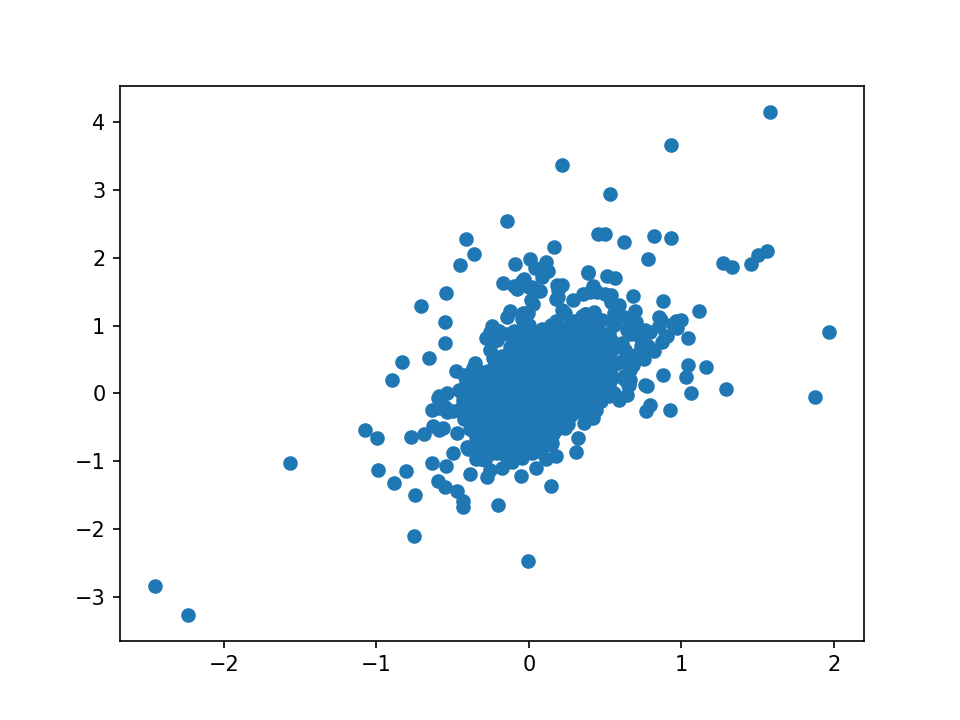

In [120]:
gr_merge = gis1_rph1_data_kemmeren.merge(gis1_rph1_data_fc, how='left', right_index=True, left_index=True)
gr_merge['sc_genename']=gr_merge.index
plt.scatter(gr_merge['gis1rph1'],gr_merge['log_gr-wt'])

In [132]:
#Plot kl v.s. sc with overlay from gis1 rph1 experiment

#Load group lists from promoter analysis
fname = os.path.normpath(data_processing_dir + '20170817_klscpka/20180410_act_sets_P1.pkl')
with open(fname, mode = 'rb') as f: 
    gene_list_dict = pickle.load(f)

kemmeren_westholm_columns = {'gis1rph1':'log_gr-wt','gis1':'log_g-wt', 'rph1':'log_r-wt'}

for kemmeren_cond, westholm_cond in kemmeren_westholm_columns.items():
    print(kemmeren_cond)
    xdata = gr_merge.loc[:,kemmeren_cond]
    ydata = gr_merge.loc[:,westholm_cond]
    color_dict = {'sc_only_act':'green', 'sc_sckl_act': 'red'}

    data = []
    #make subset for all remaining genes
    gene_subset = set(gr_merge['sc_genename'])- (set(gene_list_dict['sc_only_act']) | set(gene_list_dict['sc_sckl_act']))

    xdata_subset = xdata[gr_merge['sc_genename'].isin(gene_subset)]
    ydata_subset = ydata[gr_merge['sc_genename'].isin(gene_subset)]
    hover_subset = io_library.SC_common_name_lookup(gr_merge[gr_merge['sc_genename'].isin(gene_subset)]['sc_genename'])

    trace = pygo.Scatter(
            x = xdata_subset,
            y =  ydata_subset,
            text = hover_subset,
            mode = 'markers',
            marker = {'size': 13, 'opacity': 0.1, 'color': 'gray'},
            name = 'other'
        )

    data.append(trace)
    
    for subset in ['sc_only_act', 'sc_sckl_act']:
        gene_subset = set(gene_list_dict[subset])
        xdata_subset = xdata[gr_merge['sc_genename'].isin(gene_subset)]
        ydata_subset = ydata[gr_merge['sc_genename'].isin(gene_subset)]
        hover_subset = io_library.SC_common_name_lookup(gr_merge[gr_merge['sc_genename'].isin(gene_subset)]['sc_genename'])

        trace = pygo.Scatter(
            x = xdata_subset,
            y =  ydata_subset,
            text = hover_subset,
            mode = 'markers',
            marker = {'size': 13, 'opacity': 0.7, 'color': color_dict[subset]},
            name = subset
        )   
        data.append(trace)




    # hover_text = []
    # for ind, row in kl_sc_PKA_data.iterrows():
    #     hover_text.append(('{SC_common_name}<br>').format(SC_common_name=row['SC_common_name']))

    layout = pygo.Layout(
        font = {"size": 30}, 
        title = kemmeren_cond,
        xaxis= {
            "range":[-3, 3],
            "title":'SDC Media, Log2 intensity ratio' 
        },
        yaxis= {
            "range":[-4.5, 4.5],
            "title":'YPD Media, Log2 intensity ratio'
        }
    )


    fig = pygo.Figure(data=data, layout = layout)
    py.iplot(fig, filename=kemmeren_cond + '_delete_comparison_P1_groups')

gis1rph1
gis1
rph1


<IPython.core.display.Javascript object>


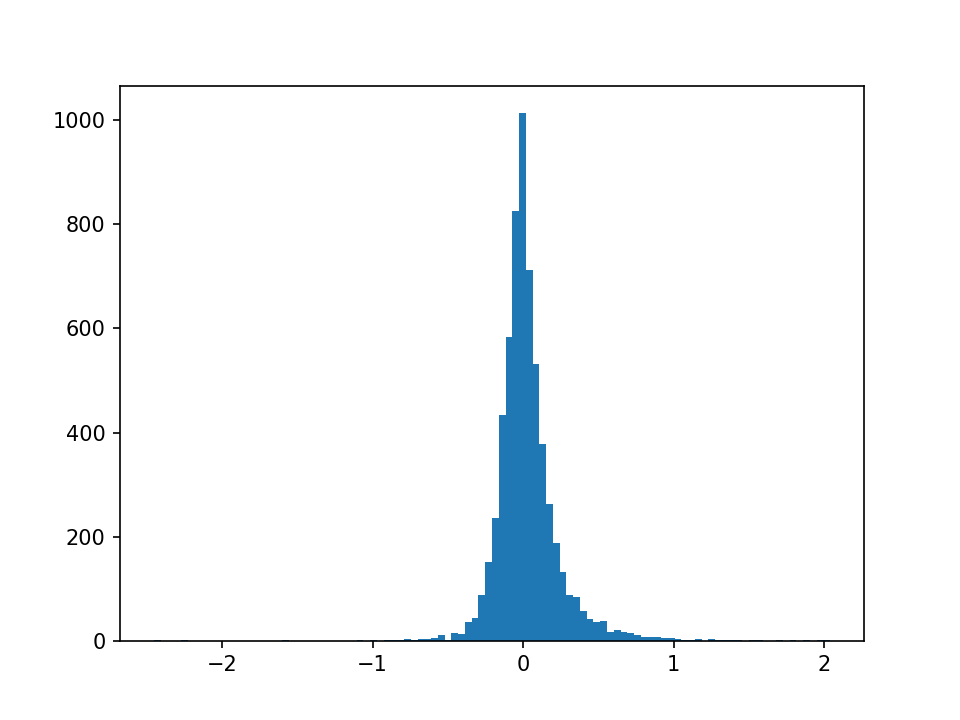

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   4.00000000e+00,   1.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   6.00000000e+00,
          1.20000000e+01,   2.00000000e+00,   1.50000000e+01,
          1.40000000e+01,   3.70000000e+01,   4.40000000e+01,
        

In [115]:

plt.hist(gis1_rph1_data_kemmeren['gis1rph1'],bins=100)